In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import community as python_louvain  # This is python-louvain package
from sklearn.manifold import MDS
import os
from tqdm.notebook import tqdm


In [2]:
# Convert distance matrix to similarity matrix if needed
def convert_distance_to_similarity(distance_matrix, sigma=1.0):
    # Apply Gaussian kernel: sim = exp(-dist²/2σ²)
    similarity_matrix = np.exp(-np.square(distance_matrix) / (2 * sigma * sigma))
    return similarity_matrix

# Create a graph from the similarity matrix
def create_graph_from_similarity(similarity_matrix, threshold=0.0):
    n = similarity_matrix.shape[0]
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(n))
    
    # Add edges with weights above threshold
    for i in range(n):
        for j in range(i+1, n):  # Only upper triangle to avoid duplicates
            if similarity_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])
    return G

# Detect communities using the Louvain method
def detect_communities(G):
    # Best partition is from the python-louvain package
    communities = python_louvain.best_partition(G, weight='weight', resolution=1)
    return communities

# Visualize the communities
def visualize_communities(G, communities, node_labels=None, figsize=(12, 10), 
                         with_labels=True, node_size=100):
    # Convert communities dict to a list for node colors
    community_list = [communities[node] for node in G.nodes()]
    
    # Get unique communities for color mapping
    unique_communities = set(communities.values())
    n_communities = len(unique_communities)
    
    plt.figure(figsize=figsize)
    
    # Use spring layout for node positions
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes colored by community
    nx.draw_networkx_nodes(G, pos, 
                          node_color=community_list, 
                          node_size=node_size)
    
    # Draw edges with transparency based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, 
                          width=1.0, 
                          alpha=0.5, 
                          edge_color='gray')
    
    # Add node labels if requested
    if with_labels:
        if node_labels is not None:
            labels = {i: label for i, label in enumerate(node_labels)}
        else:
            labels = {i: str(i) for i in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    
    plt.title(f'Graph Communities using Louvain Method (found {n_communities} communities)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize community structure with MDS for better 2D layout
def visualize_communities_mds(similarity_matrix, communities, node_labels=None, 
                             figsize=(12, 10), with_labels=True, node_size=100):
    # Convert similarity to distance (1 - similarity) for MDS
    distance_matrix = 1 - similarity_matrix
    
    # Apply MDS to get 2D coordinates
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    pos_array = mds.fit_transform(distance_matrix)
    
    # Convert positions to dictionary for NetworkX
    pos = {i: (pos_array[i, 0], pos_array[i, 1]) for i in range(len(pos_array))}
    
    # Create a graph
    G = nx.Graph()
    G.add_nodes_from(range(len(similarity_matrix)))
    
    # Get unique communities for color mapping
    community_list = [communities[node] for node in range(len(similarity_matrix))]
    unique_communities = set(communities.values())
    n_communities = len(unique_communities)
    
    plt.figure(figsize=figsize)
    
    # Draw nodes colored by community
    nx.draw_networkx_nodes(G, pos, 
                          node_color=community_list,  
                          node_size=node_size)
    
    # Add node labels if requested
    if with_labels:
        if node_labels is not None:
            labels = {i: label for i, label in enumerate(node_labels)}
        else:
            labels = {i: str(i) for i in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    
    plt.title(f'Communities using MDS Layout (found {n_communities} communities)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get summary statistics for each community
def get_community_stats(communities):
    # Count nodes in each community
    community_counts = {}
    for community_id in communities.values():
        if community_id not in community_counts:
            community_counts[community_id] = 0
        community_counts[community_id] += 1
    
    # Sort by community size
    sorted_communities = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Create a summary
    print(f"Found {len(community_counts)} communities")
    print("\nCommunity sizes:")
    for comm_id, count in sorted_communities:
        print(f"Community {comm_id}: {count} nodes")
    
    return community_counts

# Main execution function
def analyze_similarity_matrix(file_path, threshold=0.5, sigma=1.0, node_labels=None):
    # Load the matrix
    print(f"Loading matrix from {file_path}")
    matrix = np.load(file_path)
    
    # Check if it's a distance or similarity matrix
    print(f"Converting distance matrix to similarity matrix with sigma={sigma}")
    similarity_matrix = convert_distance_to_similarity(matrix, sigma)
    
    # Create graph
    print(f"Creating graph with similarity threshold={threshold}")
    G = create_graph_from_similarity(similarity_matrix, threshold)
    
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Detect communities
    print("Detecting communities using Louvain method...")
    communities = detect_communities(G)
    
    # Display statistics
    community_stats = get_community_stats(communities)
    
    # Visualize
    print("\nVisualizing communities...")
    visualize_communities(G, communities, node_labels)
    
    # Visualize with MDS
    # print("\nVisualizing communities with MDS layout...")
    # visualize_communities_mds(similarity_matrix, communities, node_labels)
    
    return G, communities, similarity_matrix

In [3]:
# Example usage:
# G, communities, similarity_matrix = analyze_similarity_matrix('similarity_matrix.npy', threshold=0.7)

file_path = "/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/datasets/levr_3k.npy"


In [4]:
matrix = np.load(file_path);

Loading matrix from /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/datasets/levr_3k.npy
Converting distance matrix to similarity matrix with sigma=0.5827678180168566
Creating graph with similarity threshold=0.75
Graph has 2914 nodes and 111656 edges
Detecting communities using Louvain method...
Found 90 communities

Community sizes:
Community 29: 782 nodes
Community 1: 661 nodes
Community 0: 534 nodes
Community 2: 518 nodes
Community 17: 330 nodes
Community 12: 2 nodes
Community 18: 2 nodes
Community 40: 2 nodes
Community 52: 2 nodes
Community 3: 1 nodes
Community 7: 1 nodes
Community 8: 1 nodes
Community 9: 1 nodes
Community 10: 1 nodes
Community 11: 1 nodes
Community 13: 1 nodes
Community 14: 1 nodes
Community 15: 1 nodes
Community 16: 1 nodes
Community 20: 1 nodes
Community 22: 1 nodes
Community 23: 1 nodes
Community 24: 1 nodes
Community 25: 1 nodes
Community 26: 1 nodes
Community 27: 1 nodes
Community 30: 1 nodes
Community 31: 1 nodes
Community 32: 1 nodes
Comm

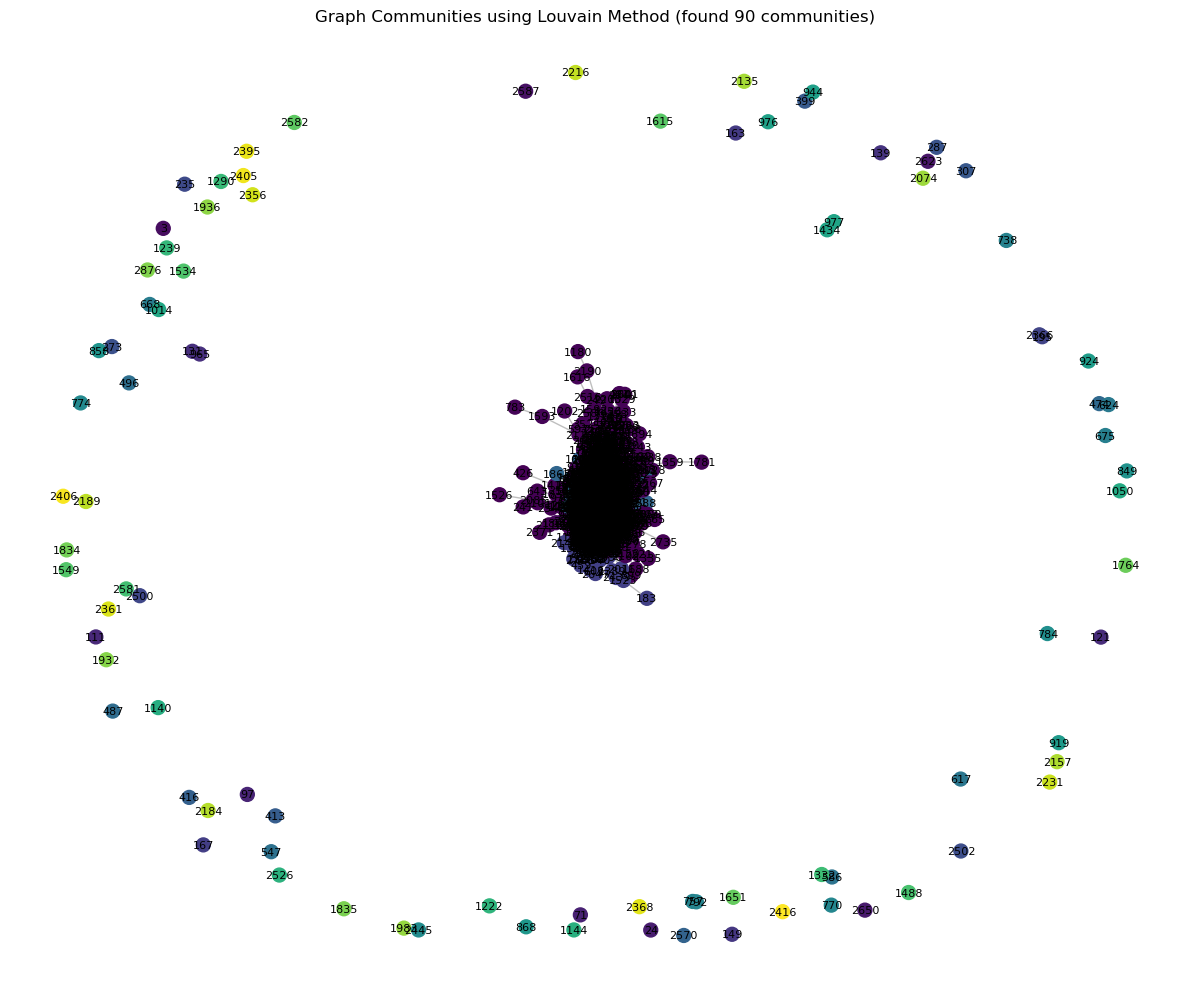

In [7]:

# If you have labels for your nodes (e.g., molecule names), put them here
# node_labels = ["Mol1", "Mol2", ...]
node_labels = None

# Adjust these parameters based on your data
# threshold = 0.8  # Minimum similarity to create an edge
# sigma = 0.0075      # Gaussian kernel width for distance->similarity conversion

sigma = np.mean(matrix)
threshold = 0.75

# Run the analysis
G, communities, similarity_matrix = analyze_similarity_matrix(
    file_path, threshold, sigma, node_labels
)

In [48]:
np.mean(matrix), np.std(matrix), np.min(matrix), np.max(matrix)

(0.008044928714444911, 0.0024631277393480917, 0.0, 0.031910263290543424)

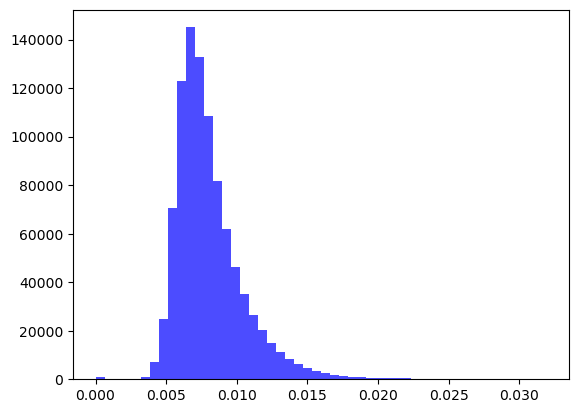

In [49]:
plt.hist(matrix.flatten(), bins=50, color='blue', alpha=0.7);

In [50]:
np.sum([1 for v in similarity_matrix.flatten() if v > 0.8]) / similarity_matrix.size

0.0598428906265679

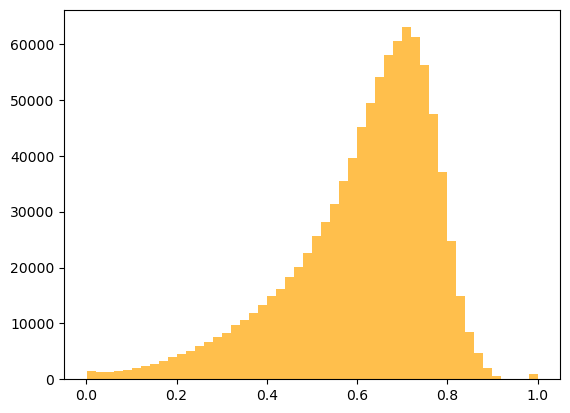

In [51]:
plt.hist(similarity_matrix.flatten(), bins=50, color='orange', alpha=0.7);

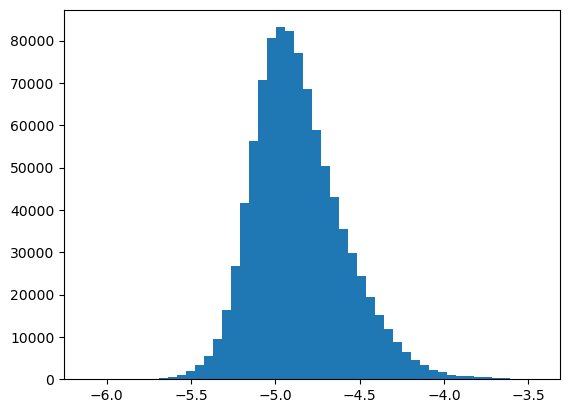

In [52]:
plt.hist(np.log([v for v in matrix.flatten() if v>0.0]), bins=50);